# Deep GP unsupervised learning

This notebook depends on [GPy](https://github.com/SheffieldML/GPy) and [PyDeepGP](https://github.com/SheffieldML/PyDeepGP). These libraries can be installed via pip:
```
pip install GPy
pip install git+https://github.com/SheffieldML/PyDeepGP.git
```

In [13]:
import deepgp
import GPy
import numpy as np
%matplotlib inline
from pylab import *

In [14]:
# Visualization Utility Functions
def ax_default(fignum, ax):
    if ax is None:
        fig = figure(fignum)
        ax = fig.add_subplot(111)
    else:
        fig = ax.figure
    return fig, ax

def meanplot(x, mu, color='#3300FF', ax=None, fignum=None, linewidth=2,**kw):
    _, axes = ax_default(fignum, ax)
    return axes.plot(x,mu,color=color,linewidth=linewidth,**kw)

def gpplot(x, mu, lower, upper, edgecol='#3300FF', fillcol='#33CCFF', ax=None, fignum=None, **kwargs):
    _, axes = ax_default(fignum, ax)

    mu = mu.flatten()
    x = x.flatten()
    lower = lower.flatten()
    upper = upper.flatten()

    plots = []

    #here's the mean
    plots.append(meanplot(x, mu, edgecol, axes))

    #here's the box
    kwargs['linewidth']=0.5
    if not 'alpha' in kwargs.keys():
        kwargs['alpha'] = 0.3
    plots.append(axes.fill(np.hstack((x,x[::-1])),np.hstack((upper,lower[::-1])),color=fillcol,**kwargs))

    #this is the edge:
    plots.append(meanplot(x, upper,color=edgecol,linewidth=0.2,ax=axes))
    plots.append(meanplot(x, lower,color=edgecol,linewidth=0.2,ax=axes))

    return plots

In [7]:
# Fetch MNIST dataset from mldata.org. 
# It takes a while.
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [78]:
# Sub-sample the dataset to make the training faster.
np.random.seed(0)
digits = [0,1,2,3,4]
N_per_digit = 100
Y = []
labels = []
for d in digits:
    imgs = mnist['data'][mnist['target']==d]
    Y.append(imgs[np.random.permutation(imgs.shape[0])][:N_per_digit])
    labels.append(np.ones(N_per_digit)*d)
Y = np.vstack(Y).astype(np.float64)
labels = np.hstack(labels)
Y /= 255.

### Intialize the Deep GP model with two hidden layer

In [79]:
m = deepgp.DeepGP([Y.shape[1],5,2],Y,kernels=[GPy.kern.RBF(5,ARD=True), GPy.kern.RBF(2,ARD=False)], num_inducing=50, back_constraint=False, encoder_dims=[[200],[200]])
m.obslayer.likelihood.variance[:] = Y.var()*0.01
for layer in m.layers:
    layer.kern.variance.fix(warning=False)
    layer.likelihood.variance.fix(warning=False)
print(m)


Name : deepgp
Objective : 83509577.45302136
Number of Parameters : 7460
Number of Optimization Parameters : 7456
Updates : True
Parameters:
  deepgp.                           |              value  |  constraints  |  priors
  obslayer.inducing_inputs          |            (50, 5)  |               |        
  obslayer.rbf.variance             |                1.0  |   +ve fixed   |        
  obslayer.rbf.lengthscale          |               (5,)  |      +ve      |        
  obslayer.Gaussian_noise.variance  |  0.000961532997497  |   +ve fixed   |        
  obslayer.Kuu_var                  |              (50,)  |      +ve      |        
  obslayer.latent_space.mean        |           (500, 5)  |               |        
  obslayer.latent_space.variance    |           (500, 5)  |      +ve      |        
  layer_1.inducing_inputs           |            (50, 2)  |               |        
  layer_1.rbf.variance              |                1.0  |   +ve fixed   |        
  layer_1.rbf.lengt

In [80]:
m.optimize(messages=1,max_iters=100)
for layer in m.layers:
    layer.kern.variance.constrain_positive(warning=False)
m.optimize(messages=1,max_iters=100)
for layer in m.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m.optimize(messages=1,max_iters=1000)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    01s26  009   5.615930e+06   1.705733e+10 
    05s49  047   3.726141e+06   3.419719e+08 
    11s68  102   3.634768e+06   2.169180e+08 
Runtime:     11s68
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    02s21  014   3.623358e+06   8.775275e+07 
    07s35  059   3.587131e+06   3.333691e+07 
    12s59  102   3.571621e+06   1.945640e+07 
Runtime:     12s59
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s19  0009  -6.526388e+04   4.670910e+08 
    02s27  0019  -8.304557e+04   3.965597e+07 
    06s58  0052  -9.386831e+04   2.270054e+06 
    20s39  0169  -1.002804e+05   1.958873e+05 
    24s60  0202  -1.009717e+05   1.620101e+05 
    40s14  0330  -1.020675e+05   1.478913e+04 
 01m47

In [81]:
print(m)


Name : deepgp
Objective : -103659.86449931537
Number of Parameters : 7460
Number of Optimization Parameters : 7460
Updates : True
Parameters:
  deepgp.                           |            value  |  constraints  |  priors
  obslayer.inducing_inputs          |          (50, 5)  |               |        
  obslayer.rbf.variance             |   0.188829274721  |      +ve      |        
  obslayer.rbf.lengthscale          |             (5,)  |      +ve      |        
  obslayer.Gaussian_noise.variance  |  0.0258173234962  |      +ve      |        
  obslayer.Kuu_var                  |            (50,)  |      +ve      |        
  obslayer.latent_space.mean        |         (500, 5)  |               |        
  obslayer.latent_space.variance    |         (500, 5)  |      +ve      |        
  layer_1.inducing_inputs           |          (50, 2)  |               |        
  layer_1.rbf.variance              |    5.53949642193  |      +ve      |        
  layer_1.rbf.lengthscale           |

### Visualize the latent space of the top layer

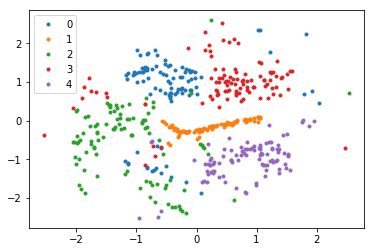

In [84]:
for d in digits:
    plot(m.layer_1.X.mean[labels==d,0],m.layer_1.X.mean[labels==d,1],'.',label=str(d))
legend()

### Visualize the latent space of the intermediate layer

In [90]:
m.obslayer.kern.lengthscale

index,deepgp.obslayer.rbf.lengthscale,constraints,priors
[0],4.26134878,+ve,
[1],5.62716590,+ve,
[2],7.00420246,+ve,
[3],5.57031881,+ve,
[4],6.35635516,+ve,


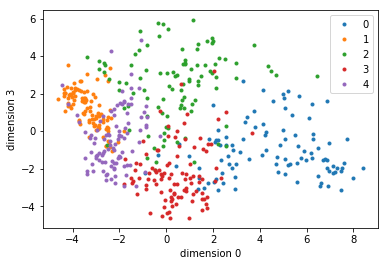

In [91]:
for d in digits:
    plot(m.obslayer.X.mean[labels==d,0],m.obslayer.X.mean[labels==d,3],'.',label=str(d))
legend()
xlabel('dimension 0')
ylabel('dimension 3')

### Draw a sample from the top hidden layer

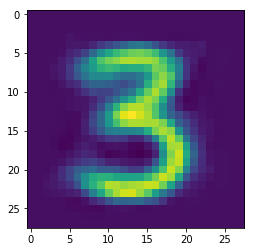

In [89]:
yt = m.predict(np.random.randn(1,2))
imshow(yt[0].reshape(28,28))